# Using OCR Bounding Boxes and Images to evaluate text confidence

In [126]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Corrupt JPEG data: bad Huffman code
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_13704/3792603332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


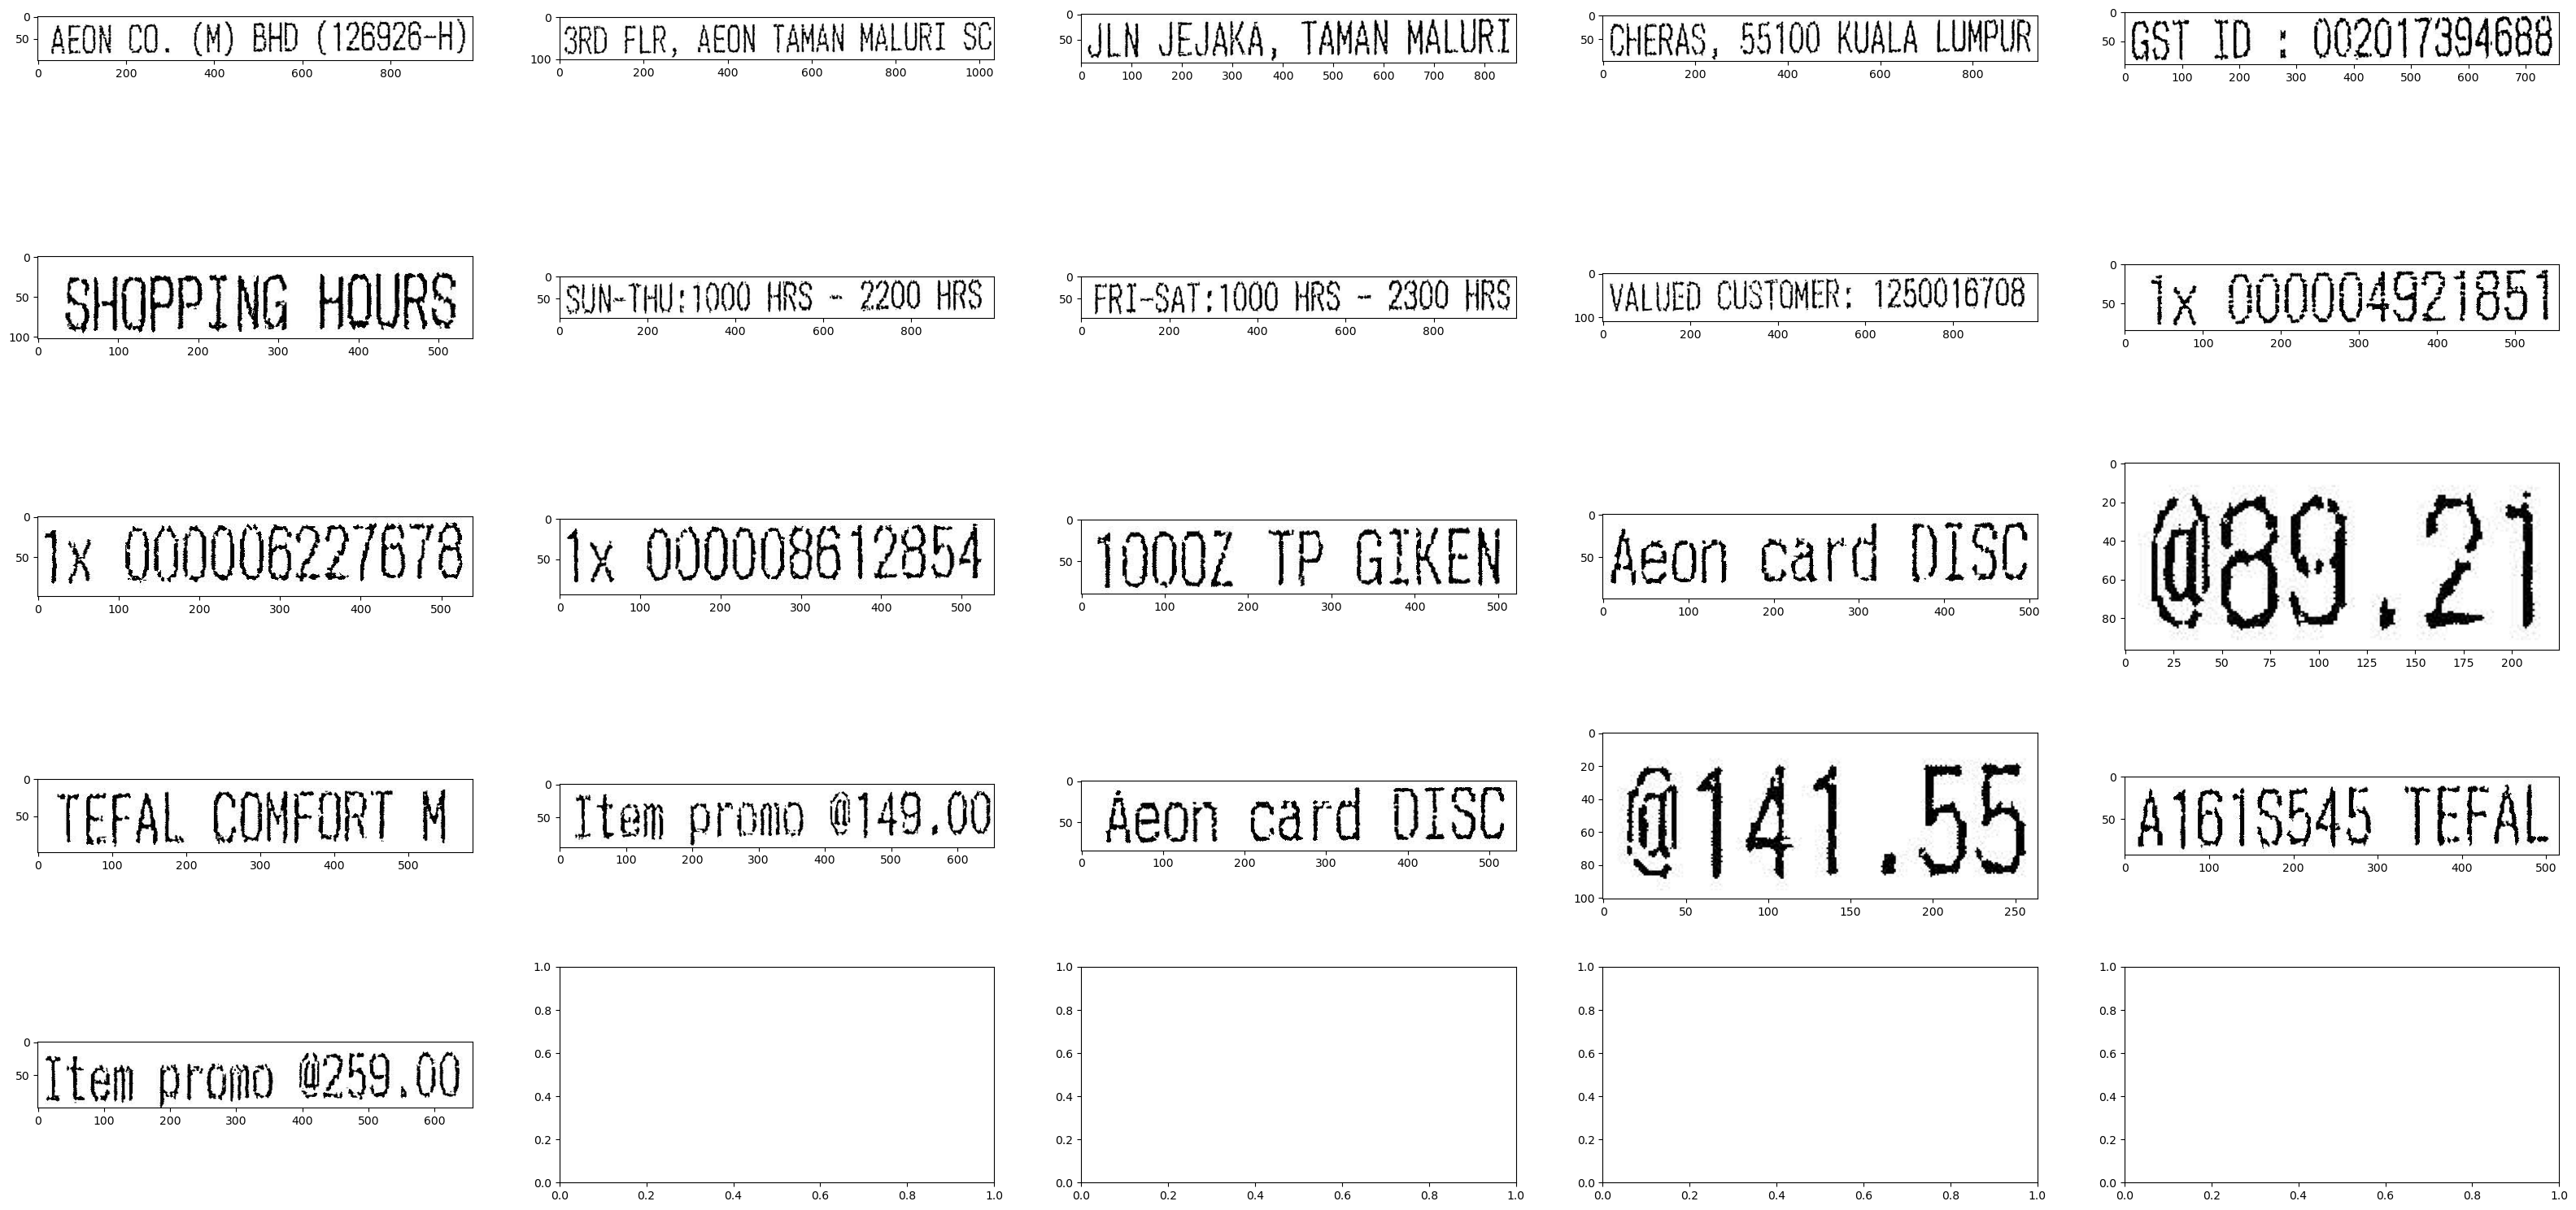

In [127]:
testfile = '00d0100894168'
img = cv2.imread(f'data/original/img/{testfile}.jpg')
imgdata = pd.read_csv(f"data/interim/ocr/{testfile}.csv")

fig, ax = plt.subplots(5,5,figsize=(40,20))
ctr = 0
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[max(int(row[1]['BB2'])-5, 0):min(int(row[1]['BB6'])+5, img.shape[0]-1), 
            max(int(row[1]['BB1'])-5,0):min(int(row[1]['BB3'])+5, img.shape[1]-1)]
        if ctr < 25:
            ax[ctr//5][ctr%5].imshow(slc)
            ctr += 1
        if ctr == 21:
            break
fig.show()


([90.400452, 29.430609, 58.778801], ['Item', 'oromo', '$259.00'], [(12, 23, 145, 95), (185, 34, 357, 99), (395, 17, 639, 90)])


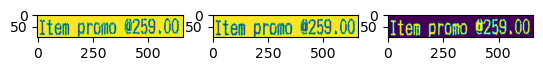

In [128]:
import pytesseract as pts

def clarity(slc, debug=False):
    """
    Returns the percentage of confidence, on average, tesseract has for each word
    """
    if debug: fig, ax = plt.subplots(1,3)
    slc2 = cv2.GaussianBlur(slc, (9,9), 1)
    slc2 = cv2.cvtColor(slc2, cv2.COLOR_BGR2GRAY)
    if debug: ax[0].imshow(slc2)
    slc3 = 255 - slc2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2))
    slc3 = cv2.morphologyEx(slc3, cv2.MORPH_CLOSE, kernel, iterations=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))
    slc3 = 255 - cv2.morphologyEx(slc3, cv2.MORPH_CLOSE, kernel, iterations=0)
    slc3 = slc3.astype(np.uint8)
    if debug: ax[1].imshow(slc3)
    _, slc3 = cv2.threshold(slc3, 200, 255, cv2.THRESH_BINARY_INV)
    if debug: ax[2].imshow(slc3)
    text = pts.image_to_data(cv2.cvtColor(slc3, cv2.COLOR_BGR2RGB), output_type='data.frame', config="--psm 7")
    if debug: plt.imshow(slc3)
    text = text[text['text'].notna()]
    if len(text) == 0:
        return [0], [""], ((0, 0, 1, 1),)
    coords = []
    for row in text.iterrows():
        coords.append((int(row[1]['left']), 
            int(row[1]['top']), 
            int(row[1]['width'])+int(row[1]['left']), 
            int(row[1]['height'])+int(row[1]['top'])))

    return list(text['conf']), list(text['text']), coords

print(clarity(slc, debug=True))

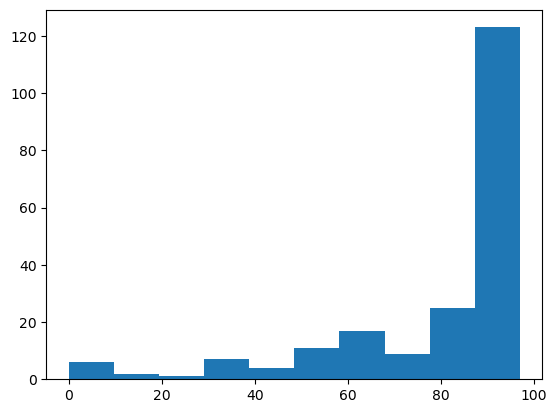

In [129]:
res = []
words = []
bounds = []
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[max(int(row[1]['BB2'])-5, 0):min(int(row[1]['BB6'])+5, img.shape[0]-1), 
            max(int(row[1]['BB1'])-5,0):min(int(row[1]['BB3'])+5, img.shape[1]-1)]
        c, t, b = clarity(slc)
        [res.append(s) for s in c]
        [words.append(s) for s in t]
        [bounds.append((s[0]+int(row[1]['BB1'])-5, s[1]+int(row[1]['BB2'])-5, s[2]+int(row[1]['BB1'])-5, s[3]+int(row[1]['BB2'])-5)) for s in b]
plt.hist(res)
plt.show()

[(1553, 469, 1690, 537), (1729, 468, 1822, 535), (1876, 462, 1966, 542), (2011, 464, 2113, 532), (2158, 456, 2493, 539), (1518, 566, 1620, 634), (1661, 565, 1786, 642), (1835, 562, 1972, 632), (2015, 560, 2183, 631), (2222, 557, 2424, 629), (2468, 557, 2535, 625), (1588, 665, 1690, 736), (1729, 663, 1963, 742), (2011, 660, 2183, 732), (2222, 657, 2424, 730), (1553, 764, 1785, 845), (1834, 760, 2007, 834), (2046, 759, 2218, 832), (2259, 756, 2463, 829), (1658, 865, 1759, 937), (1802, 864, 1866, 935), (1917, 883, 1928, 932), (1976, 858, 2393, 935), (1799, 962, 2077, 1036), (2116, 959, 2288, 1032), (1513, 1052, 1786, 1142), (1813, 1052, 1941, 1142), (1975, 1060, 2077, 1131), (2116, 1092, 2146, 1103), (2187, 1058, 2323, 1130), (2361, 1056, 2463, 1128), (1520, 1160, 1786, 1234), (1808, 1150, 1936, 1240), (1974, 1157, 2077, 1228), (2116, 1190, 2148, 1200), (2187, 1155, 2323, 1226), (2361, 1154, 2463, 1228), (1235, 1265, 1442, 1335), (1481, 1258, 1786, 1332), (1841, 1255, 2183, 1328), (1347, 

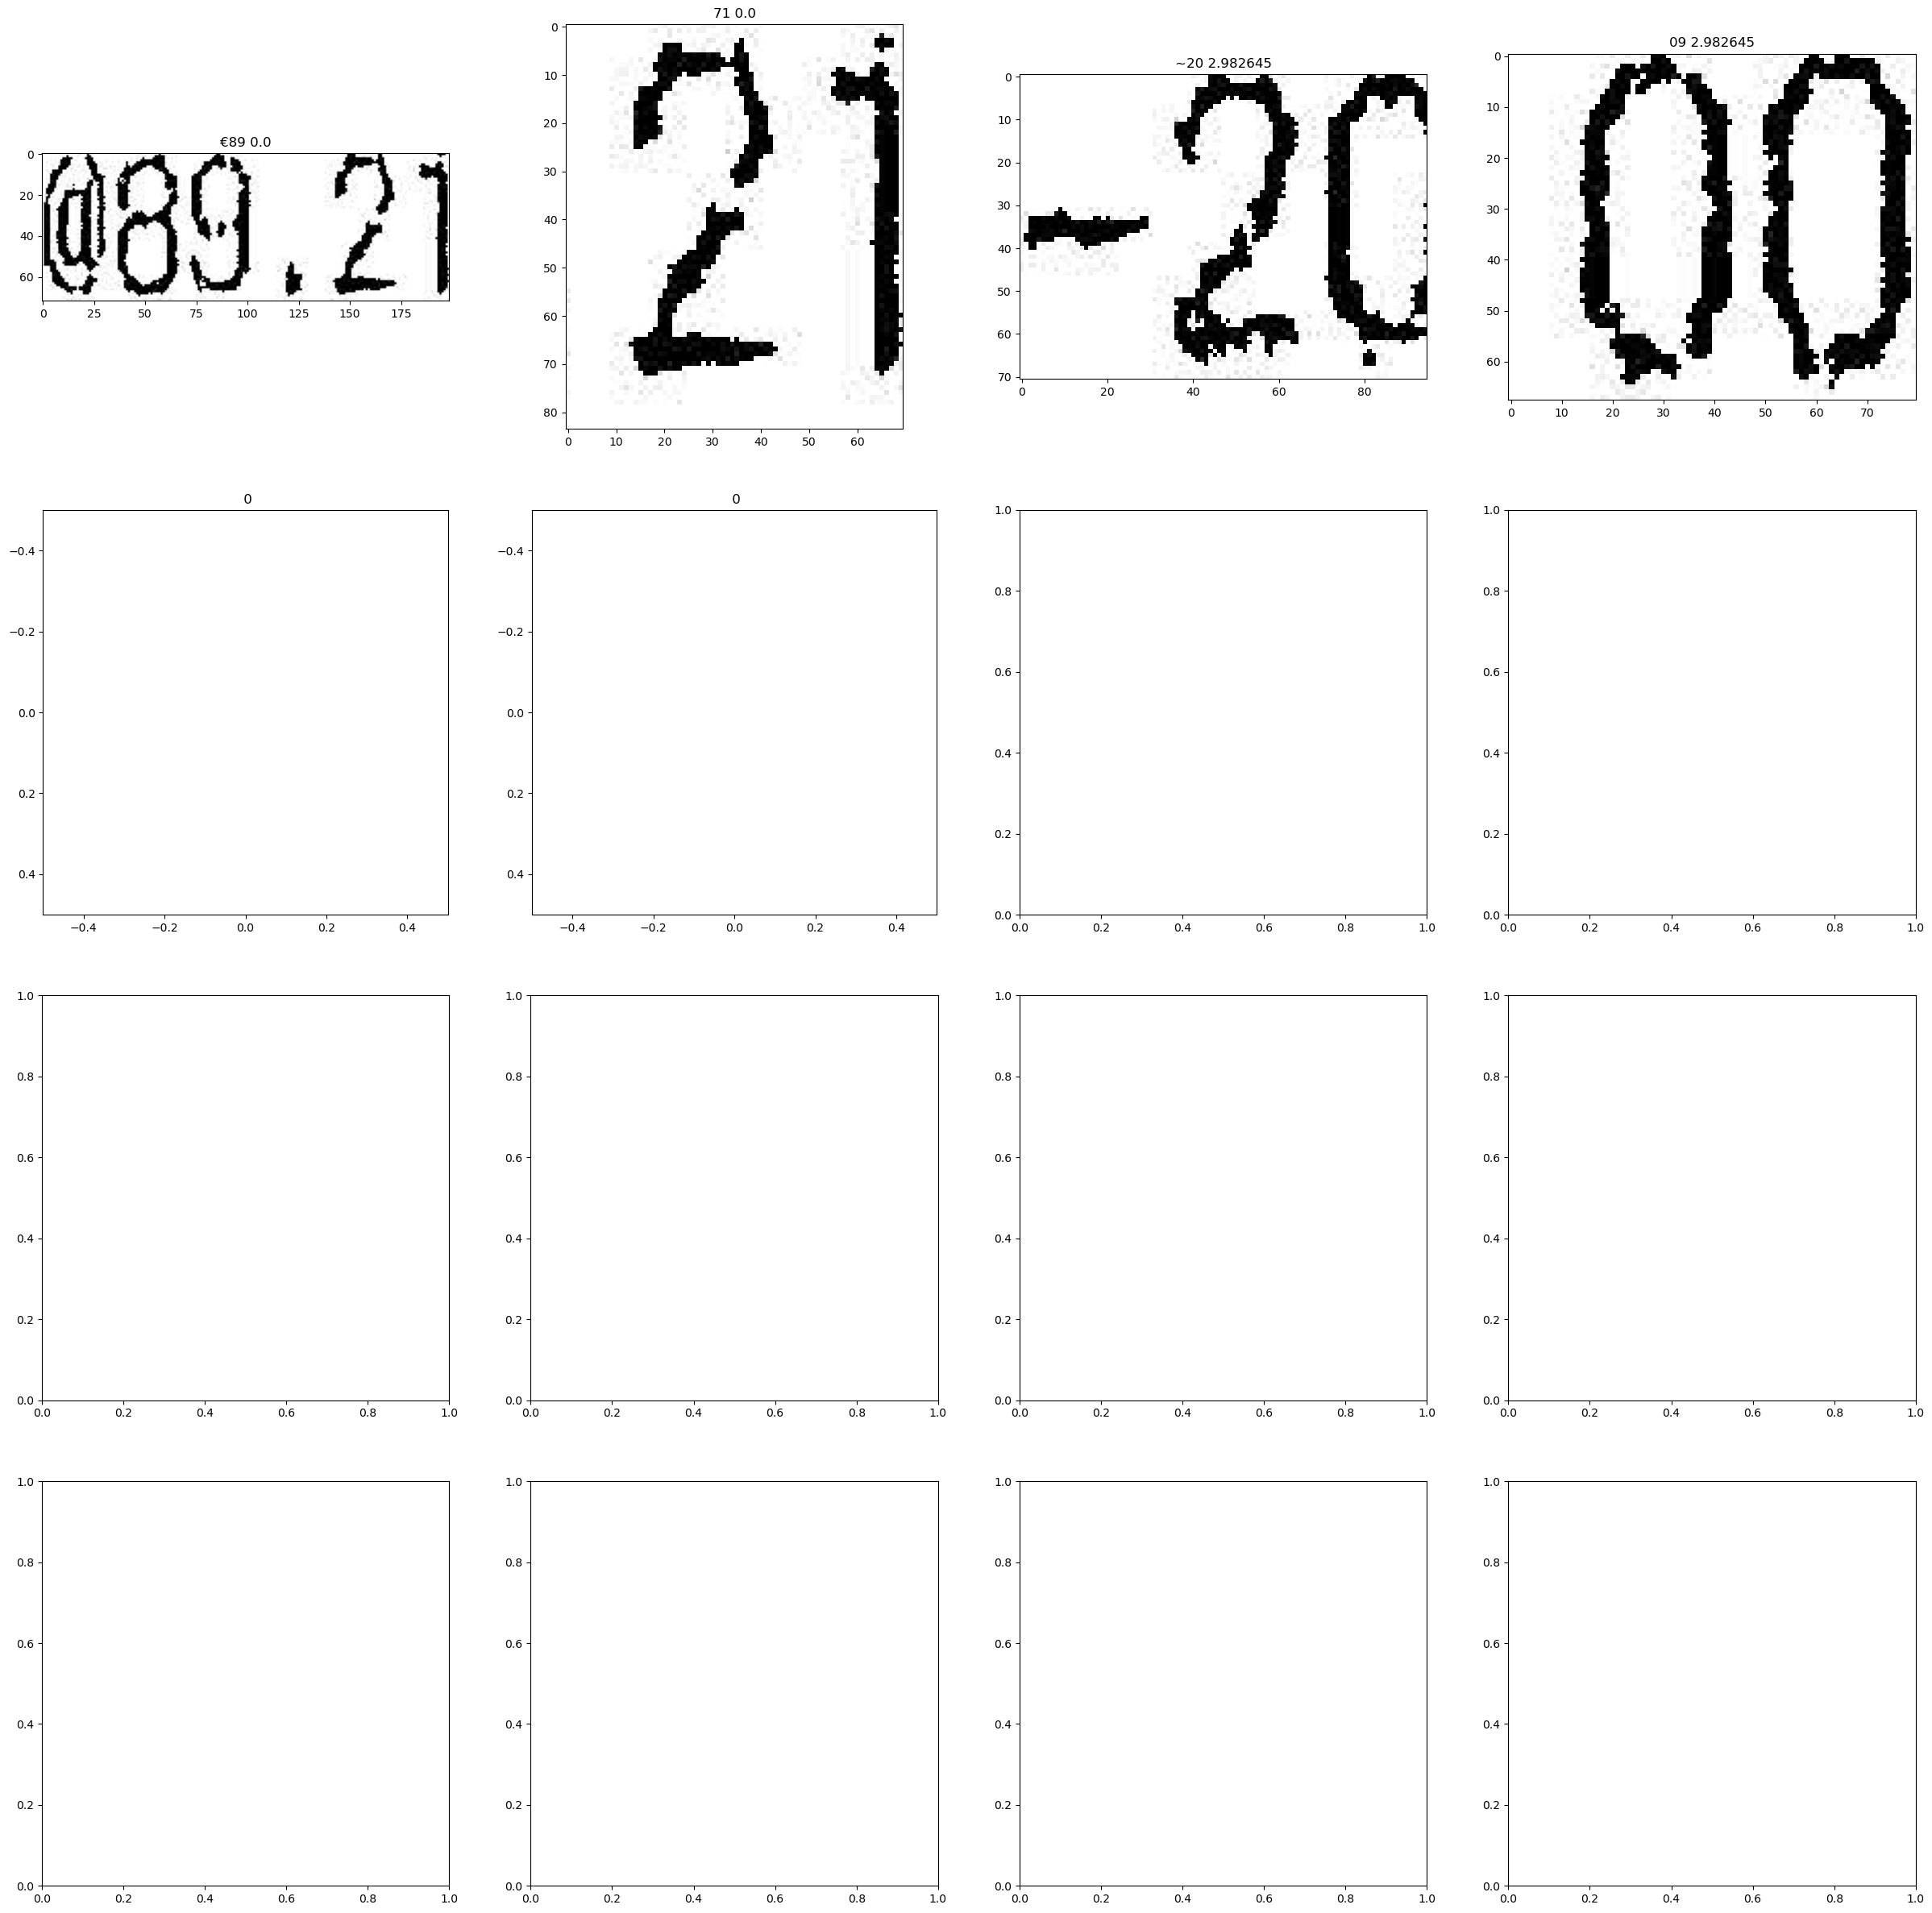

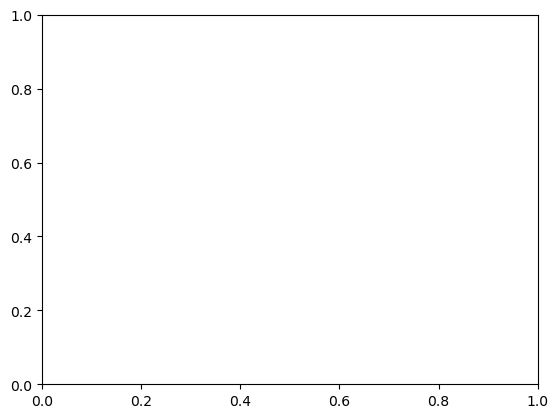

In [130]:
fig, ax = plt.subplots(4,4,figsize=(30,30))
ctr = 0
print(bounds)
for i in range(len(words)):
    if res[i] < 10:
        if ctr < 16:
            ax[ctr//4][ctr%4].imshow(img[bounds[i][1]:bounds[i][3],bounds[i][0]:bounds[i][2]])
            ax[ctr//4][ctr%4].set_title(words[i] + " " + str(res[i]))
            ctr += 1
fig, ax = plt.subplots(1,1)